<a href="https://colab.research.google.com/github/abhiWriteCode/Balanced-Cartpole/blob/master/notebook_in_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Install dependencies
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay matplotlib scikit-video > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

In [4]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.distributions import Categorical

import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import time
import utils
from collections import deque


torch.manual_seed(0) # set random seed

torch.__version__

'1.2.0'

In [5]:
env = gym.make("CartPole-v0")
env.seed(0) # reproducible, since RL has high variance

[0]

In [6]:
print ("Enviornment has observation space = {}".format(env.observation_space))

Enviornment has observation space = Box(4,)


In [7]:
n_actions = env.action_space.n
print ("Number of possible actions that the agent can choose from = {}".format(n_actions))

Number of possible actions that the agent can choose from = 2


In [0]:
def create_model():
    model = nn.Sequential(
        nn.Linear(4, 16),
        nn.ReLU(inplace=True),
        nn.Linear(16, n_actions),
        nn.Softmax(dim=1)
    )
    return model

In [0]:
def choose_action(model, state, eval=False):
    
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    probs = model(state).cpu()

    if eval:
        action = probs.argmax()
        return action.item()

    m = Categorical(probs)
    action = m.sample()
    return action.item(), m.log_prob(action)

In [0]:
def normalize(x):
    x -= np.mean(x)
    x /= np.std(x)
    return x

def discount_rewards(rewards, gamma=0.99): 
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(0, len(rewards))):
        # update the total discounted reward as before
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R
        
    return normalize(discounted_rewards)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
def reinforce(model, optimizer, n_episodes=1000, gamma=0.99, plot=True):
    
    smoothed_reward = utils.LossHistory(smoothing_factor=0.8)
    plotter = utils.PeriodicPlotter(sec=5, xlabel='Iterations', ylabel='Rewards')
    print_every = 50
    moving_scores = deque(maxlen=100)

    for i_episode in range(1, n_episodes + 1):
        saved_log_probs = []
        rewards = []

        # Restart the environment
        observation = env.reset()
        done = False
        while not done:
            action, log_prob = choose_action(model, observation)
            observation, reward, done, _ = env.step(action)

            saved_log_probs.append(log_prob)
            rewards.append(reward)
        
        total_reward = sum(rewards)
        moving_scores.append( total_reward )
        smoothed_reward.append( total_reward )

        R = discount_rewards(rewards, gamma=gamma)
        policy_loss = torch.cat([-log_prob * r for log_prob, r in zip(saved_log_probs, R)]).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if plot:
            plotter.plot(smoothed_reward.get())
        else:
            if i_episode % print_every == 0:
                print(f'[Episode {i_episode :4}] Avg Reward : {np.mean(moving_scores):6.2f} | Current Reward : {total_reward:6.2f}')

In [13]:
# %%time

pole = create_model().to(device)
opt = torch.optim.Adam(pole.parameters(), lr=1e-2)

try:
    reinforce(pole, opt, n_episodes=1000, gamma=1.0, plot=False)
except KeyboardInterrupt:
    pass

[Episode   50] Avg Reward :  33.92 | Current Reward :  75.00
[Episode  100] Avg Reward :  90.38 | Current Reward : 200.00
[Episode  150] Avg Reward : 161.25 | Current Reward : 200.00
[Episode  200] Avg Reward : 182.36 | Current Reward : 145.00
[Episode  250] Avg Reward : 156.98 | Current Reward : 120.00
[Episode  300] Avg Reward : 135.41 | Current Reward : 172.00
[Episode  350] Avg Reward : 163.32 | Current Reward : 200.00
[Episode  400] Avg Reward : 190.36 | Current Reward : 200.00
[Episode  450] Avg Reward : 200.00 | Current Reward : 200.00
[Episode  500] Avg Reward : 200.00 | Current Reward : 200.00


In [0]:
def reinforce_2(model, optimizer, n_episodes=1000, gamma=0.99):
    
    print_every = 100
    scores = []
    moving_scores = deque(maxlen=100)

    for i_episode in range(1, n_episodes + 1):
        saved_log_probs = []
        rewards = []

        # Restart the environment
        observation = env.reset()
        done = False
        while not done:
            action, log_prob = choose_action(model, observation)
            observation, reward, done, _ = env.step(action)

            saved_log_probs.append(log_prob)
            rewards.append(reward)
                
        total_reward = sum(rewards)
        scores.append(total_reward)
        moving_scores.append(total_reward)

        # Moderate Performence
        discounts = [gamma**i for i in range(len(rewards)+1)]
        # discounted_rewards = [a*b for a,b in zip(discounts, rewards)] # values of 'discounted_rewards in between [0, 1]
        R = sum([a*b for a,b in zip(discounts, rewards)]) 

        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print(f'[Episode {i_episode :4}] Avg Reward : {np.mean(moving_scores):6.2f} | Current Reward : {total_reward:6.2f}')
        
    return scores

[Episode  100] Avg Reward :  23.02 | Current Reward :  24.00
[Episode  200] Avg Reward :  37.78 | Current Reward :  32.00
[Episode  300] Avg Reward :  53.93 | Current Reward : 102.00
[Episode  400] Avg Reward :  86.56 | Current Reward :  64.00
[Episode  500] Avg Reward : 115.86 | Current Reward : 200.00
[Episode  600] Avg Reward : 153.48 | Current Reward : 118.00
[Episode  700] Avg Reward : 151.01 | Current Reward :  72.00
[Episode  800] Avg Reward : 184.83 | Current Reward : 200.00
[Episode  900] Avg Reward : 200.00 | Current Reward : 200.00
[Episode 1000] Avg Reward : 200.00 | Current Reward : 200.00


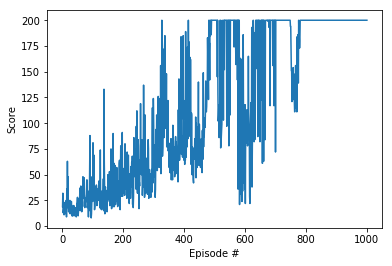

In [16]:
# %%time

pole_2 = create_model().to(device)
optimizer_2 = optim.Adam(pole_2.parameters(), lr=1e-2)
scores = None

try:
    scores = reinforce_2(pole_2, optimizer_2, n_episodes=1000, gamma=1)
except KeyboardInterrupt:
    pass

# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

observation space: Box(4,)
action space: Discrete(2)
Episode 100	Average Score: 21.21
Episode 200	Average Score: 21.43
Episode 300	Average Score: 27.02
Episode 400	Average Score: 46.54
Episode 500	Average Score: 35.43
Episode 600	Average Score: 51.35
Episode 700	Average Score: 50.46
Episode 800	Average Score: 72.63
Episode 900	Average Score: 91.15
Episode 1000	Average Score: 144.62


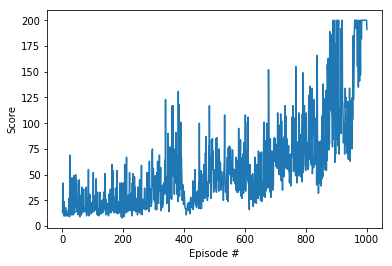

In [19]:
env = gym.make('CartPole-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)


policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def uda_reinforce(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores = []
    moving_scores = deque(maxlen=100)
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores.append(sum(rewards))
        moving_scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(moving_scores)))
        
    return scores
    
scores = uda_reinforce()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [0]:
checkpoint = 'checkpoint.pt'

In [0]:
# torch.save(pole.state_dict(), checkpoint)

In [0]:
# Evaluation Model

pole_eval = create_model().to(device)
pole_eval.load_state_dict(torch.load(checkpoint))
pole_eval.eval()

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=64, out_features=2, bias=True)
  (3): Softmax(dim=1)
)

In [0]:
def save_video_of_model(model, env_name, filename='agent.mp4'):  
    import skvideo.io
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(40, 30))
    display.start()

    env = gym.make(env_name)
    obs = env.reset()

    out = skvideo.io.FFmpegWriter(filename)
    done = False
    
    model.eval()
    with torch.no_grad():
        while not done: 
            frame = env.render(mode='rgb_array')
            out.writeFrame(frame)

            action = choose_action(model, obs, eval=True)
            
            obs, reward, done, info = env.step(action)
    out.close()
    model.train()
    print ("Successfully saved into {}!".format(filename))

save_video_of_model(pole_eval, "CartPole-v0", filename='cartpole_agent.mp4')

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


AttributeError: ignored

In [0]:
from IPython.display import HTML
import io, base64
video = io.open('./pong_agent.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<video controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
</video>'''.format(encoded.decode('ascii')))

FileNotFoundError: ignored